In [1]:
## versions:
## Python    : 3.11.5
## numpy     : 1.26.0
## torch     : 2.1.0
## pandas    : 2.1.1

# licensed under the Creative Commons - Attribution-NonCommercial 4.0
# International license (CC BY-NC 4.0):
# https://creativecommons.org/licenses/by-nc/4.0/. 

import os
import shutil
import numpy as np
import pandas as pd
import torch as t
import matplotlib.pyplot as plt
from copy import deepcopy

from common.torch.ops import empty_gpu_cache
from data_utils.forecast import tryJSON, Struct, read_config, default_settings, str_indexed_csv
from data_utils.forecast import init_target_data, load_exog_data, make_training_fn, generate_quantiles
from data_utils.forecast import pickle_results, read_pickle, output_figs

import data_utils.flu as flu_utils
import data_utils.covid_hub as covid_utils

import warnings
%config InlineBackend.figure_formats = ["svg"]
plt.style.use("dark_background")
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(category.__name__, message)
warnings.filterwarnings("ignore",category=FutureWarning)


In [2]:
current_year = 2024

dest = os.path.join("storage","download")
flu_utils.download_forecast_hub(dest)
flu_utils.download_flusurv_net(dest)
flu_utils.download_flu_surveil(dest)

flu_utils.download_weather(current_year, dest)

covid_utils.download_covid_surveil(dest)


In [3]:

idx, _ = flu_utils.read_flu_data()
flu_utils.read_weather_data(idx)

idx, _ = covid_utils.read_covid_weekly()
covid_utils.read_weather_data(idx)

In [4]:
def init_rstate(configfile, cut, settings, domain_specs, ensemble_fn, cut_weight_fn=None):
    rstate = read_config(configfile)
    rstate.cut = cut
    
    rstate, settings = init_target_data(rstate, settings)
    rstate, settings = load_exog_data(rstate, settings, domain_specs)

    if cut_weight_fn is not None: settings.cut_weights = cut_weight_fn(rstate, settings)

    rstate.settings_list = ensemble_fn(settings, domain_specs)
    rstate.pretrained_models = [None for x in rstate.settings_list]
    
    return rstate, settings


def generate_ensemble(rstate, ens_fn=np.median):
    mu_fc={}
    var_fc={}
    empty_gpu_cache()
    training_fn = make_training_fn(rstate)

    ## ensemble loop
    for i, set_i in enumerate(rstate.settings_list):
        model_name = rstate.output_prefix+"_"+str(i)
        model_suffix = str(rstate.cut) if rstate.cut is not None else str(rstate.data_index[-1])
        model_name = model_name+"_"+model_suffix
        print("training ",model_name)
        mu_fc[model_name], var_fc[model_name] = training_fn(model_name, set_i, rstate.pretrained_models[i]) 

    mu_fc["ensemble"] = ens_fn(np.stack([mu_fc[k] for k in mu_fc]),axis=0)
    var_fc["ensemble"] = ens_fn(np.stack([var_fc[k] for k in var_fc]),axis=0)
    rstate.mu_fc = mu_fc
    rstate.var_fc = var_fc

    rstate = generate_quantiles(rstate)

    return rstate


def delete_model_dir(rstate):
    if rstate.delete_models:
        try:
            shutil.rmtree(rstate.snapshot_dir)
        except:
            pass


In [5]:

def run_test(configfile, settingsfile, domain_fn, cut, ensemble_fn, random_reps=None, pretrain_list_fn=None, n_iter=None, init_LR=None, cut_weight_fn=None, series_figs=[], ens_reduce=np.median, adj_iter=None, adj_LR=None):
    ## if adj_*, train more when there is more data; otherwise use values from settings.json
    settings = default_settings(settingsfile)
    if cut is not None:
        if adj_iter is not None: settings.iterations = adj_iter(cut)
        if adj_LR is not None: settings.init_LR = adj_LR(cut)
    if n_iter is not None: settings.iterations = n_iter
    if init_LR is not None: settings.init_LR = init_LR

    domain_specs = domain_fn()
    if random_reps is not None: domain_specs.random_reps = random_reps
    
    rstate, settings = init_rstate(configfile, cut, settings, domain_specs, ensemble_fn, cut_weight_fn)

    if pretrain_list_fn is not None:
        rstate.pretrained_models = pretrain_list_fn(domain_specs)

    rstate = generate_ensemble(rstate, ens_reduce)

    pickle_results(rstate)
    output_figs(rstate, rstate.settings_list[0].horizon, 
                series_figs, 
                60,
                colors=["white","yellow"],figsize=(5,3),plot_mean=True)

    delete_model_dir(rstate)

    return rstate


In [6]:
def write_hub_file(df, date_stamp, popfile, outdir):

    pops = str_indexed_csv(popfile).iloc[:,0].rename("pop")
    pops["US"] = pops.sum()

    df_hub = pd.merge(df,pops,left_on="series_name",right_index=True)
    df_hub["per100k"] = df_hub["value"]
    df_hub["value"] = (df_hub["per100k"] * (df_hub["pop"] / 100000.0)).round(2)
    df_hub["output_type_id"] = pd.to_numeric(df_hub["output_type_id"], errors="coerce")

    keep_cols = ["reference_date",
        "target",
        "horizon",
        "target_end_date",
        "location",
        "output_type",
        "output_type_id",
        "value"]

    filename = date_stamp.strftime("%Y-%m-%d") + "-OHT_JHU-nbxd.csv"

    df_hub.loc[(df_hub["output_type"]=="quantile") & (df_hub["horizon"]<4) , 
            keep_cols].to_csv(os.path.join(outdir,filename),index=False)

In [7]:
def covid_ensemble(template, specs):
    settings_list = []
    for j in range(specs.random_reps):
        for opt in specs.lookback_opts:
            x = deepcopy(template)
            x.lookback = opt
            x.nbeats_hidden_dim = opt * 2 * 6 * 5
            settings_list.append(x)
    return settings_list

def flu_ensemble(template, specs):
    settings_list = []
    for j in range(specs.random_reps):
        for opt in specs.lookback_opts:
            x = deepcopy(template)
            x.lookback = opt
            x.nbeats_hidden_dim = opt * 2 * 6 * 8
            settings_list.append(x)
    return settings_list

## pretrained models corresponding to each entry in the ensemble
def covid_pre_2024(specs):
    pretrain_dir = os.path.join("storage","pretrained_hhs_surveil_weekly")
    file_list = []
    for j in range(specs.random_reps):
        for opt in specs.lookback_opts:
            filename = "covid2024_"+str(opt)+"H_"+str(j+1)+".pt"
            file_list.append(os.path.join(pretrain_dir,filename))
    return file_list

def flu_pre24_pf(specs):
    data_dir = "storage"
    file_list = []
    for j in range(specs.random_reps):
        for opt in specs.lookback_opts:
            filepath = "flu24_"+str(opt)+"H_"+str(j+1)+".pt"
            file_list.append(os.path.join(data_dir,"peakfinder_2024",filepath))
    return file_list

def flu_pre24_ond(specs):
    data_dir = "storage"
    file_list = []
    for j in range(specs.random_reps):
        for opt in specs.lookback_opts:
            filepath = "flu24_"+str(opt)+"H_"+str(j+1)+".pt"
            file_list.append(os.path.join(data_dir,"original_plus_2024",filepath))
    return file_list


training  flu_0_2024-12-07


training  flu_1_2024-12-07


training  flu_2_2024-12-07


training  flu_3_2024-12-07


training  flu_4_2024-12-07


training  flu_5_2024-12-07


training  flu_6_2024-12-07


training  flu_7_2024-12-07


training  flu_8_2024-12-07


training  flu_9_2024-12-07


training  flu_10_2024-12-07


training  flu_11_2024-12-07


training  flu_12_2024-12-07


training  flu_13_2024-12-07


training  flu_14_2024-12-07


training  flu_15_2024-12-07


training  flu_16_2024-12-07


training  flu_17_2024-12-07


training  flu_18_2024-12-07


training  flu_19_2024-12-07


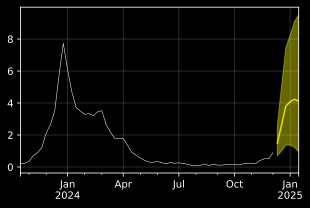

In [8]:
## for forecast hub: the "reference date" is 14 days after the data end date
## (the data usually becomes available 6 days after the data end date)

csv_name = "forecast_peakfinder"
## config for flusurv-net (pretraining data) forecasts points to flunet_samples_per100k.csv
rstate = run_test(configfile="config_flu_pretrain.json", settingsfile="settings_flu.json", domain_fn=flu_utils.domain_defaults,
                  cut=None, ensemble_fn=flu_ensemble, random_reps=5, pretrain_list_fn=flu_pre24_pf, n_iter=0)
df, date_stamp = flu_utils.output_df(rstate, 14)
flu_utils.append_forecasts(df, os.path.join("storage",csv_name+".csv"))



training  flu_0_2024-12-07


training  flu_1_2024-12-07


training  flu_2_2024-12-07


training  flu_3_2024-12-07


training  flu_4_2024-12-07


training  flu_5_2024-12-07


training  flu_6_2024-12-07


training  flu_7_2024-12-07


training  flu_8_2024-12-07


training  flu_9_2024-12-07


training  flu_10_2024-12-07


training  flu_11_2024-12-07


training  flu_12_2024-12-07


training  flu_13_2024-12-07


training  flu_14_2024-12-07


training  flu_15_2024-12-07


training  flu_16_2024-12-07


training  flu_17_2024-12-07


training  flu_18_2024-12-07


training  flu_19_2024-12-07


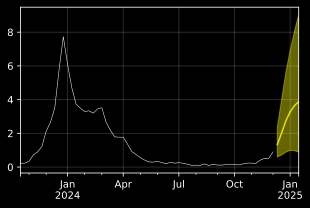

In [9]:

csv_name = "forecast_orig_noise_down"
rstate = run_test(configfile="config_flu_pretrain.json", settingsfile="settings_flu.json", domain_fn=flu_utils.domain_defaults,
                  cut=None, ensemble_fn=flu_ensemble, random_reps=5, pretrain_list_fn=flu_pre24_ond, n_iter=0)
df, date_stamp = flu_utils.output_df(rstate, 14)
flu_utils.append_forecasts(df, os.path.join("storage",csv_name+".csv"))


training  flu_0_2024-12-07


training  flu_1_2024-12-07


training  flu_2_2024-12-07


training  flu_3_2024-12-07


training  flu_4_2024-12-07


training  flu_5_2024-12-07


training  flu_6_2024-12-07


training  flu_7_2024-12-07


training  flu_8_2024-12-07


training  flu_9_2024-12-07


training  flu_10_2024-12-07


training  flu_11_2024-12-07


training  flu_12_2024-12-07


training  flu_13_2024-12-07


training  flu_14_2024-12-07


training  flu_15_2024-12-07


training  flu_16_2024-12-07


training  flu_17_2024-12-07


training  flu_18_2024-12-07


training  flu_19_2024-12-07


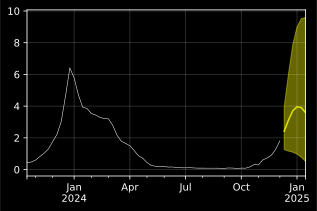

In [10]:

csv_name = "fc_flusight_pf"
## config for flusight forecasts points to flusight_truth_per100k.csv
rstate = run_test(configfile="config_flu.json", settingsfile="settings_flu.json", domain_fn=flu_utils.domain_defaults,
                  cut=None, ensemble_fn=flu_ensemble, random_reps=5, pretrain_list_fn=flu_pre24_pf, n_iter=100, init_LR=0.0001)
df, date_stamp = flu_utils.output_df(rstate, 14)
flu_utils.append_forecasts(df, os.path.join("storage",csv_name+".csv"))

write_hub_file(df, date_stamp, "storage/flu_training/flusight_populations.csv", "storage/flu_output")


training  nbxd_0_2024-12-07


training  nbxd_1_2024-12-07


training  nbxd_2_2024-12-07


training  nbxd_3_2024-12-07


training  nbxd_4_2024-12-07


training  nbxd_5_2024-12-07


training  nbxd_6_2024-12-07


training  nbxd_7_2024-12-07


training  nbxd_8_2024-12-07


training  nbxd_9_2024-12-07


training  nbxd_10_2024-12-07


training  nbxd_11_2024-12-07


training  nbxd_12_2024-12-07


training  nbxd_13_2024-12-07


training  nbxd_14_2024-12-07


training  nbxd_15_2024-12-07


training  nbxd_16_2024-12-07


training  nbxd_17_2024-12-07


training  nbxd_18_2024-12-07


training  nbxd_19_2024-12-07


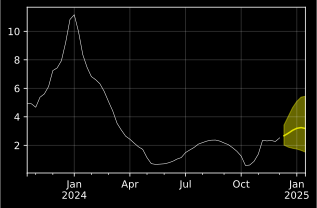

In [11]:

rstate = run_test(configfile="config_covid.json", settingsfile="settings_covid.json", domain_fn=covid_utils.domain_defaults,
                  cut=None, ensemble_fn=covid_ensemble, random_reps=5, pretrain_list_fn=covid_pre_2024, n_iter=100)

df, date_stamp = covid_utils.output_df(rstate, 14)

write_hub_file(df, date_stamp, "storage/training_data/fips_pops.csv", "storage/output")
